<a href="https://colab.research.google.com/github/gabrielcordeiro2/LOL-Champion-Analysis/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import en_core_web_sm

Read file dataframe:

In [ ]:
lol_df = pd.read_csv("lol_df.csv")

#### __Top 20 champions with most voices:__

In [ ]:
voices_df = lol_df.filter(items=["champion","voice_line","is_spoken"])
voices = voices_df.groupby("champion")["voice_line"].count()

names_x = np.array(voices.sort_values(ascending=False).head(20).keys())
values_y = np.array(voices.sort_values(ascending=False).head(20))

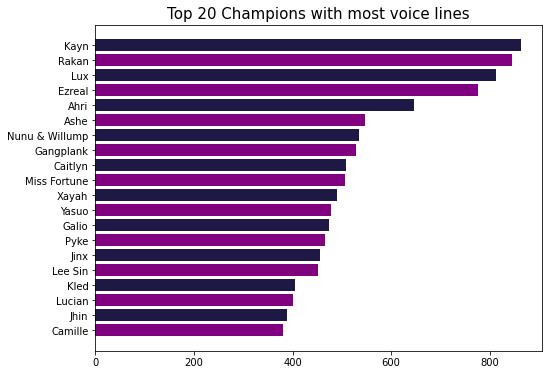

In [ ]:
plt.figure(figsize=(8,6))
plt.barh(names_x, values_y, color=('#1e1845', 'purple'))
plt.title('Top 20 Champions with most voice lines', size="15")
ax = plt.gca()
ax.invert_yaxis()
plt.show()

#### __Top 20 most mentioned champions by other champions:__

In [ ]:
filter_champs = {
    'Aurelion Sol':'Aurelion',
    'Dr. Mundo':'Mundo',
    'Jarvan IV':'Jarvan',
    'Kayn':'Rhaast',
    "Kog'Maw":"Kog",
    'Nunu & Willump':'Nunu',
    'Renata Glasc':'Renata',
    'Tahm Kench':'Tahm',
    'Twisted Fate':'Twisted',
    'Xin Zhao':'Xin',
}

In [ ]:
champ_list = np.array(voices.keys())
filtered_champs = champ_list
filtered_champs = list(map(filter_champs.get, filtered_champs, filtered_champs))

In [ ]:
stat_voices = []
for champ in filtered_champs:
    voice_count = voices_df[(voices_df["voice_line"].str.contains(
       f"{champ}[.]|{champ}[,]|{champ}[']|{champ}[!]|{champ}[?]|{champ} ", regex=True))]
    voice_count = voice_count[(voice_count["is_spoken"] == True)&(voice_count["champion"] != "Kayn")&
       (voice_count["champion"] != champ)&(~voice_count["champion"].str.contains(champ))]["voice_line"].count()
    stat_voices.append([champ,voice_count])

In [ ]:
table_voices = pd.DataFrame(stat_voices, columns=["champion", "count_voices"]).sort_values("count_voices", ignore_index=True, ascending=False).head(20)
x = np.array(table_voices["champion"])
y = np.array(table_voices["count_voices"])

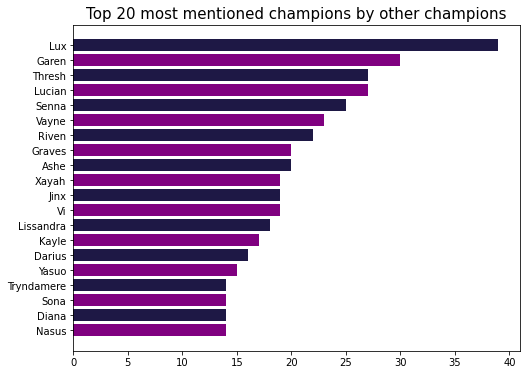

In [ ]:
plt.figure(figsize=(8,6))
plt.barh(x, y, color=('#1e1845', 'purple'))
plt.title('Top 20 most mentioned champions by other champions', size="15")
ax = plt.gca()
ax.invert_yaxis()
plt.show()

#### __Distribution of genders:__

In [ ]:
male = lol_df["champion"][lol_df["gender"]=="Male"].drop_duplicates().count()
female = lol_df["champion"][lol_df["gender"]=="Female"].drop_duplicates().count()
lgbt = lol_df["champion"][lol_df["gender"]=="LGBTQIA+"].drop_duplicates().count()

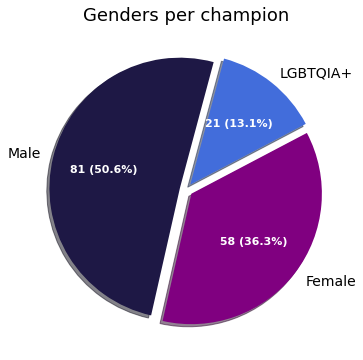

In [ ]:
genders = np.array([male, female, lgbt])
labels = ["Male", "Female", "LGBTQIA+"]
colors = ['#1e1845','purple','#426ddb']
explode = [0.05, 0.05, 0.05]
total = sum(genders)

plt.figure(figsize=(8,6))
_, _, config = plt.pie(genders, labels=labels, explode=explode, colors=colors, textprops={'fontsize': 14},
        shadow=True, startangle=75, autopct=lambda p: '{:.0f}'.format(p*total/100) + ' ({:.1f}%)'.format(p))
plt.setp(config, **{'color':'white', 'fontweight':'demi', 'fontsize':11})
plt.title("Genders per champion", size="18")
plt.show()

#### __Champions mentioning regions:__

In [ ]:
regions_df = lol_df.filter(items=["champion","voice_line"])
regions = ['Bandle', 'Bilgewater', 'Demacia', 'Ionia', 'Ixtal', 'Noxus', 'Piltover', 
           'Isles', 'Shurima', 'Targon', 'Freljord', 'Void', 'Zaun']

In [ ]:
regions_list = []
for region in regions:
    mention_count = regions_df[["voice_line"]][regions_df["voice_line"].str.contains(region, regex=True)]["voice_line"].count()
    regions_list.append([region,mention_count])

regions_count_df = pd.DataFrame(regions_list, columns=["region", "mention_count"])
correction = {'Bandle':'Bandle City', 'Freljord':'The Freljord', 'Isles':'Shadow Isles', 'Void':'The Void'}
regions_count_df.replace({"region": correction}, inplace=True)

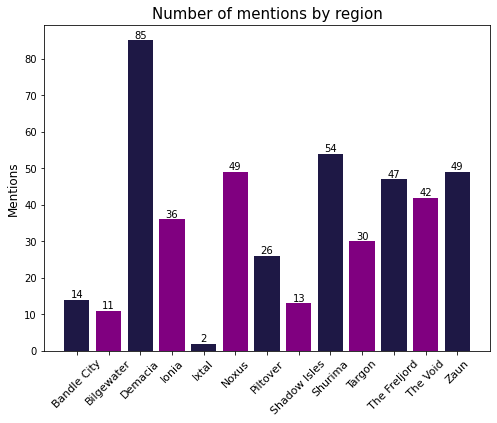

In [ ]:
name_region = np.array(regions_count_df["region"])
count_region = np.array(regions_count_df["mention_count"])

plt.figure(figsize=(8,6))
plt.bar(name_region, count_region, color=('#1e1845', 'purple'))
plt.title('Number of mentions by region', size="15")
[plt.text(name_region[i], count_region[i], count_region[i], ha="center", va="bottom") for i in range(len(count_region))]
plt.xticks(rotation = 45,fontsize=11)
plt.ylabel("Mentions", fontsize=12)
plt.show()

#### __Most used words in voice lines:__

In [ ]:
lines = lol_df.filter(items=["voice_line"])
all_lines = " ".join(line for line in lines["voice_line"])
len(all_lines) # Number of words

1043891

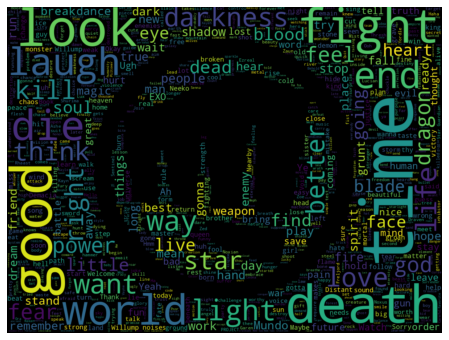

In [ ]:
pln = en_core_web_sm.load()
stopwords = pln.Defaults.stop_words
stopwords.update(set(STOPWORDS))
stopwords.update(["don't", "know", "need", "let", "hey", "mf", 
                  "got", "thing", "oh", "em", "come", "ain't"])

lol_mask = np.array(Image.open("files/logo.jpg"))

wordcloud = WordCloud(stopwords=stopwords, background_color='black', colormap='viridis',
                      width=2000, height=2000, max_words=1000, mask=lol_mask,
                      max_font_size=200, min_font_size=1).generate(all_lines)

fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.show()